In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
!pip install -U imbalanced-learn
!pip install ydata-profiling
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
global df_banco, resultados

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=f5c24217df63638423dc6eadf7a90fdfec7a3c5900876631710a51e5bfb84f82
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [46]:
df_banco = pd.read_csv("https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/fraud_dataset_example.csv")
df_banco.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [47]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            101613 non-null  int64  
 1   type            101613 non-null  object 
 2   amount          101613 non-null  float64
 3   nameOrig        101613 non-null  object 
 4   oldbalanceOrg   101613 non-null  float64
 5   newbalanceOrig  101613 non-null  float64
 6   nameDest        101613 non-null  object 
 7   oldbalanceDest  101613 non-null  float64
 8   newbalanceDest  101613 non-null  float64
 9   isFraud         101613 non-null  int64  
 10  isFlaggedFraud  101613 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


In [48]:
df_banco.shape

(101613, 11)

In [49]:
def procesar_datos(df):
    global type_dummy, type2_dummy

    # Crea una nueva variable type2 con la primera letra de las columnas nameOrig y nameDest
    df['type2'] = df['nameOrig'].str[0] + df['nameDest'].str[0]

    # Realiza One Hot Encoding para las columnas type y type2
    type_dummy = pd.get_dummies(df['type'], prefix='type', dtype=int)
    type2_dummy = pd.get_dummies(df['type2'], prefix='type2', dtype=int)

    # Combina los dataframes resultantes con el dataframe original
    df = pd.concat([df, type_dummy, type2_dummy], axis=1)

    return df

In [50]:
# Llama la función procesar_datos con df_banco como argumento
df_banco = procesar_datos(df_banco)
df_banco

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,CM,0,0,0,1,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,CM,0,0,0,1,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,CC,0,0,0,0,1,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,CC,0,1,0,0,0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,CM,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0,CM,0,0,0,1,0,0,1
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0,CC,0,1,0,0,0,1,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0,CM,0,0,0,1,0,0,1
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0,CC,0,0,0,0,1,1,0


In [51]:
df_banco = df_banco.drop(['type','nameOrig', 'nameDest', 'isFlaggedFraud','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], axis=1)

In [52]:
df_banco

,step,amount,isFraud,type2,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,CM,0,0,0,1,0,0,1
1,1,1864.28,0,CM,0,0,0,1,0,0,1
2,1,181.00,1,CC,0,0,0,0,1,1,0
3,1,181.00,1,CC,0,1,0,0,0,1,0
4,1,11668.14,0,CM,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,7477.02,0,CM,0,0,0,1,0,0,1
101609,10,282252.35,0,CC,0,1,0,0,0,1,0
101610,10,17289.01,0,CM,0,0,0,1,0,0,1
101611,10,1347146.45,0,CC,0,0,0,0,1,1,0


In [53]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   step           101613 non-null  int64  
 1   amount         101613 non-null  float64
 2   isFraud        101613 non-null  int64  
 3   type2          101613 non-null  object 
 4   type_CASH_IN   101613 non-null  int64  
 5   type_CASH_OUT  101613 non-null  int64  
 6   type_DEBIT     101613 non-null  int64  
 7   type_PAYMENT   101613 non-null  int64  
 8   type_TRANSFER  101613 non-null  int64  
 9   type2_CC       101613 non-null  int64  
 10  type2_CM       101613 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 8.5+ MB


In [54]:
# Check for duplicates
duplicates = df_banco[df_banco.duplicated()]

In [55]:

print(duplicates)

        step    amount  isFraud type2  type_CASH_IN  type_CASH_OUT  \
1543       1    663.34        0    CM             0              0   
4768       4    354.75        0    CM             0              0   
9091       7   5238.34        0    CM             0              0   
9246       7  12700.77        0    CM             0              0   
11104      7   1849.50        0    CM             0              0   
...      ...       ...      ...   ...           ...            ...   
100707    10  24598.54        0    CM             0              0   
100960    10  13329.34        0    CM             0              0   
101009    10  13027.50        0    CM             0              0   
101073    10  17355.58        0    CM             0              0   
101574    10   3079.39        0    CM             0              0   

        type_DEBIT  type_PAYMENT  type_TRANSFER  type2_CC  type2_CM  
1543             0             1              0         0         1  
4768             0 

In [56]:
df_unique = df_banco.drop_duplicates()

In [57]:
df_unique

,step,amount,isFraud,type2,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,CM,0,0,0,1,0,0,1
1,1,1864.28,0,CM,0,0,0,1,0,0,1
2,1,181.00,1,CC,0,0,0,0,1,1,0
3,1,181.00,1,CC,0,1,0,0,0,1,0
4,1,11668.14,0,CM,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,7477.02,0,CM,0,0,0,1,0,0,1
101609,10,282252.35,0,CC,0,1,0,0,0,1,0
101610,10,17289.01,0,CM,0,0,0,1,0,0,1
101611,10,1347146.45,0,CC,0,0,0,0,1,1,0


In [58]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101518 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   step           101518 non-null  int64  
 1   amount         101518 non-null  float64
 2   isFraud        101518 non-null  int64  
 3   type2          101518 non-null  object 
 4   type_CASH_IN   101518 non-null  int64  
 5   type_CASH_OUT  101518 non-null  int64  
 6   type_DEBIT     101518 non-null  int64  
 7   type_PAYMENT   101518 non-null  int64  
 8   type_TRANSFER  101518 non-null  int64  
 9   type2_CC       101518 non-null  int64  
 10  type2_CM       101518 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 9.3+ MB


In [59]:
# Verifica si hay valores nulos en el DataFrame
hay_nulos = df_unique.isnull().values.any()

if hay_nulos:
    print("Hay valores nulos en el conjunto de datos.")
else:
    print("No hay valores nulos en el conjunto de datos.")

No hay valores nulos en el conjunto de datos.


In [60]:
df_banco = df_unique

In [61]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101518 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   step           101518 non-null  int64  
 1   amount         101518 non-null  float64
 2   isFraud        101518 non-null  int64  
 3   type2          101518 non-null  object 
 4   type_CASH_IN   101518 non-null  int64  
 5   type_CASH_OUT  101518 non-null  int64  
 6   type_DEBIT     101518 non-null  int64  
 7   type_PAYMENT   101518 non-null  int64  
 8   type_TRANSFER  101518 non-null  int64  
 9   type2_CC       101518 non-null  int64  
 10  type2_CM       101518 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 9.3+ MB


In [62]:
df_banco.describe()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
count,101518.000000,1.015180e+05,101518.000000,101518.000000,101518.000000,101518.000000,101518.000000,101518.000000,101518.000000,101518.000000
mean,8.523158,1.742372e+05,0.001143,0.202309,0.308359,0.009969,0.393773,0.085591,0.606227,0.393773
std,1.821088,3.451457e+05,0.033784,0.401723,0.461818,0.099345,0.488588,0.279760,0.488588,0.488588
min,1.000000,3.200000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,1.003125e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,5.359998e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,10.000000,2.126652e+05,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,10.000000,1.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


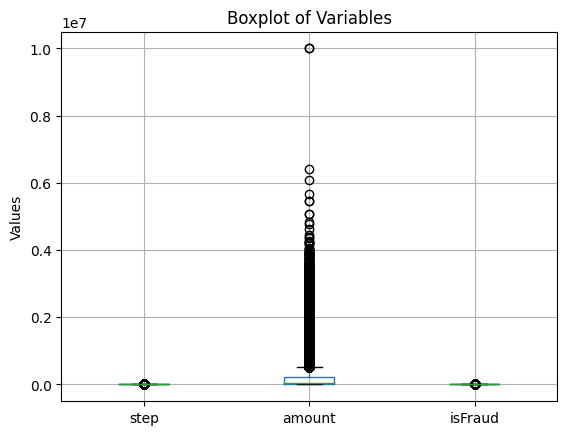

In [63]:
# Create a boxplot
df_banco.boxplot(column=['step', 'amount','isFraud'])
plt.title('Boxplot of Variables')
plt.ylabel('Values')
plt.show()

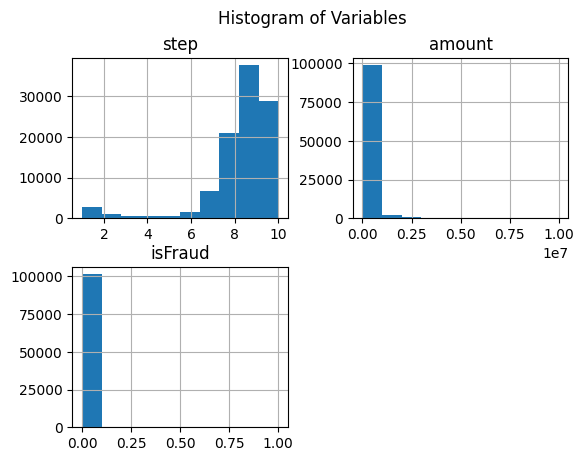

In [64]:
# Create histograms
df_banco[['step', 'amount','isFraud']].hist()
plt.suptitle('Histogram of Variables')
plt.show()

In [67]:
df_banco = df_banco.drop(['type2'],axis = 1)

<Axes: >

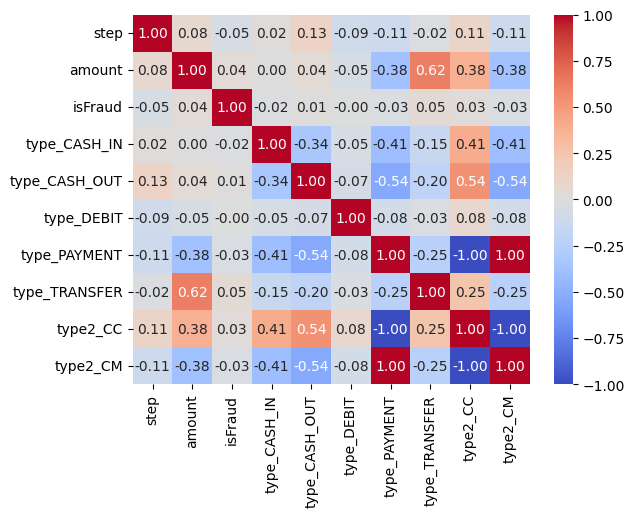

In [68]:
sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")


In [69]:
# Calcula la correlación de Pearson entre todas las columnas
correlacion = df_banco.corr()

# Imprime la matriz de correlación
print(correlacion)

                   step    amount   isFraud  type_CASH_IN  type_CASH_OUT  \
step           1.000000  0.076107 -0.051505      0.019219       0.130750   
amount         0.076107  1.000000  0.035998      0.000487       0.039377   
isFraud       -0.051505  0.035998  1.000000     -0.017033       0.014667   
type_CASH_IN   0.019219  0.000487 -0.017033      1.000000      -0.336262   
type_CASH_OUT  0.130750  0.039377  0.014667     -0.336262       1.000000   
type_DEBIT    -0.094002 -0.049458 -0.003394     -0.050534      -0.067001   
type_PAYMENT  -0.111112 -0.381333 -0.027259     -0.405878      -0.538137   
type_TRANSFER -0.016004  0.617841  0.049059     -0.154075      -0.204282   
type2_CC       0.111112  0.381333  0.027259      0.405878       0.538137   
type2_CM      -0.111112 -0.381333 -0.027259     -0.405878      -0.538137   

               type_DEBIT  type_PAYMENT  type_TRANSFER  type2_CC  type2_CM  
step            -0.094002     -0.111112      -0.016004  0.111112 -0.111112  
amount   